# **Installing Oputna**

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.7 MB/s eta 0:00:00


## **Importing libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

In [2]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [6]:
 train_df = pd.read_csv('train.csv')
 test_df = pd.read_csv('test.csv')


print("Train shape:", train_df.shape)
print( "Test shape:", test_df.shape)

Train shape: (15533, 18)
Test shape: (5225, 17)


# **Feature Engineering**

In [8]:

for df in [train_df, test_df]:
    df['BMI'] = df['Weight'] / (df['Height']**2)
    # Add another potential feature
    df['Age_x_BMI'] = df['Age'] * df['BMI']



print("✅ Feature engineering complete (BMI, Age_x_BMI).")

✅ Feature engineering complete (BMI, Age_x_BMI).


# **BMI Distribution**

/tmp/ipython-input-1799409803.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='BMI_Category', palette='viridis')


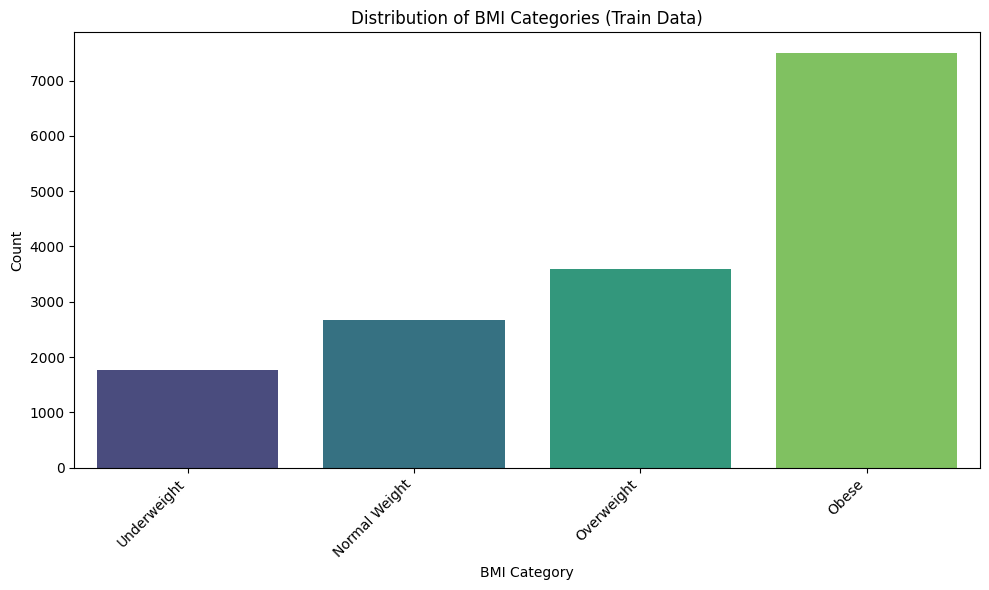

 BMI Category histogram created.


In [9]:
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal Weight'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'


train_df['BMI_Category'] = train_df['BMI'].apply(bmi_category)


bmi_order = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
train_df['BMI_Category'] = pd.Categorical(train_df['BMI_Category'], categories=bmi_order, ordered=True)



plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='BMI_Category', palette='viridis')
plt.title('Distribution of BMI Categories (Train Data)')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(" BMI Category histogram created.")

# **Feature Selection**

In [10]:
X = train_df.drop(columns=['WeightCategory', 'id'])
y_strings = train_df['WeightCategory']
test_ids = test_df['id']
X_test = test_df.drop(columns=['id'])


le = LabelEncoder()
y = le.fit_transform(y_strings)



cat_cols = X.select_dtypes(include=['object']).columns.tolist()
# Remove 'BMI_Category' from numeric columns as it's a string representation
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
if 'BMI_Category' in num_cols:
  num_cols.remove('BMI_Category')


print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Age_x_BMI']


# **Train Test Split**

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ***Preprocessing + model pipeline***

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        # Use OneHotEncoder for categorical columns
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        # Pass numeric columns through without changes
        ('num', 'passthrough', num_cols)
    ]
)

def create_pipeline(params=None):
    if params is None:
        params = {}
    model = XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y)), # Use the numeric 'y'
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        **params
    )
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

# ***Hyperparameter Tuning(no data leakage)***

In [13]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
    }

    pipeline = create_pipeline(params)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    # Cross-validate on the training set (X_train, y_train)
    # y_train is now numeric, so this will work
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_te = y_train[train_idx], y_train[test_idx]

        pipeline.fit(X_tr, y_tr)
        preds = pipeline.predict(X_te)
        scores.append(accuracy_score(y_te, preds))

    return np.mean(scores)

print("🔍 Running Optuna tuning (no leakage)...")
# Suppress Optuna's trial logging for a cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("✅ Best params:", study.best_params)

🔍 Running Optuna tuning (no leakage)...


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Best params: {'max_depth': 3, 'learning_rate': 0.12240443611559593, 'n_estimators': 292, 'subsample': 0.8659422425877278, 'colsample_bytree': 0.6920680219725612, 'min_child_weight': 7, 'gamma': 0.3759958362057034, 'reg_lambda': 3.2030702283686123, 'reg_alpha': 0.02415586968148431}


# ***Training Model***

In [14]:
final_pipeline = create_pipeline(study.best_params)
# Train on the full training set
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC', 'MTRANS']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE', 'BMI',
                                                   'Age_x_BMI'])])),
                ('model',
                 XGBClassifier(base_sc...
                               gamma=0.3759958362057034, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.12240443611559593, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=7, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=292, n_jobs=None, num_class=7, ...))])

# ***Evalution***


 Validation Accuracy: 0.9050531058899259

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.92      0.94      0.93       374
      Normal_Weight       0.88      0.90      0.89       469
     Obesity_Type_I       0.89      0.87      0.88       441
    Obesity_Type_II       0.96      0.97      0.96       481
   Obesity_Type_III       0.99      1.00      0.99       597
 Overweight_Level_I       0.82      0.75      0.78       369
Overweight_Level_II       0.81      0.85      0.83       376

           accuracy                           0.91      3107
          macro avg       0.90      0.90      0.90      3107
       weighted avg       0.90      0.91      0.90      3107



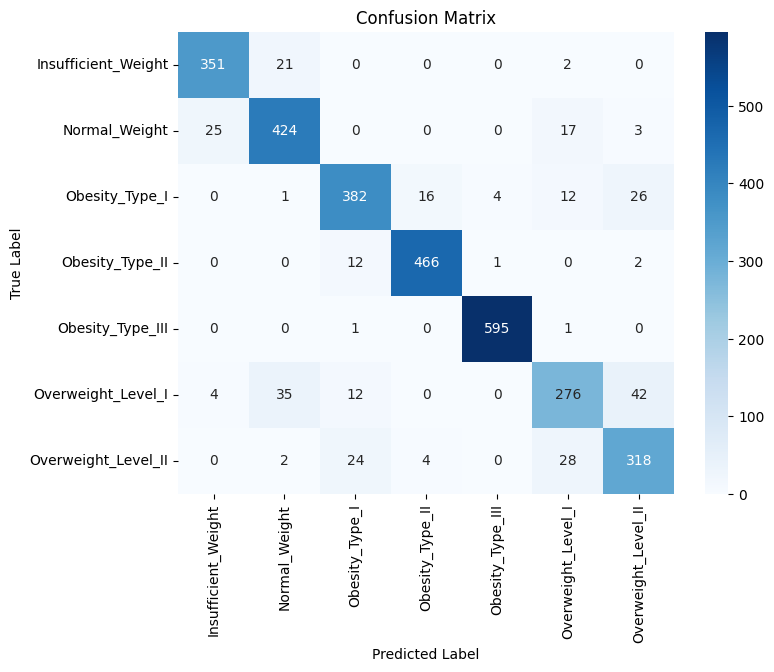

In [15]:
y_pred = final_pipeline.predict(X_val)
print("\n Validation Accuracy:", accuracy_score(y_val, y_pred))

# Decode y_val and y_pred for a readable classification report
y_val_labels = le.inverse_transform(y_val)
y_pred_labels = le.inverse_transform(y_pred)

print("\nClassification Report:\n", classification_report(y_val_labels, y_pred_labels))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ***Prediction On Test Data***

In [16]:
test_pred_numeric = final_pipeline.predict(X_test)


test_pred_labels = le.inverse_transform(test_pred_numeric)


submission = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_pred_labels # Use the readable string labels
})
submission.to_csv('submissio.csv', index=False)
print("submission.csv created successfully!")

submission.csv created successfully!


In [17]:

from google.colab import files
files.download('submissio.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import nbformat

with open("ML_obesity_Classifier_XGBoost.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Delete problematic widget metadata
if "widgets" in nb.get("metadata", {}):
    nb["metadata"].pop("widgets")

# Save a clean copy
with open("ML_obesity_Classifier_XGBoost_clean.ipynb", "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

FileNotFoundError: [Errno 2] No such file or directory: 'ML_obesity_Classifier_XGBoost.ipynb'

In [31]:
!pwd
!ls


/content
drive  sample_data  submissio.csv  test.csv  train.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# then navigate to where your notebook is, e.g.:
%cd /content/drive/MyDrive/ML_Project/
!ls


In [29]:
!find /content/drive/MyDrive -name "*.ipynb"


/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb
/content/drive/MyDrive/Colab Notebooks/mlProject1__90_8XGBOOST.ipynb
/content/drive/MyDrive/Colab Notebooks/mlprojectRANDOMFOREST.ipynb
/content/drive/MyDrive/Colab Notebooks/ML_Obesity_Classifier_Random_Forest.ipynb
/content/drive/MyDrive/Colab Notebooks/mlProject1__90_8XGBOOST_clean.ipynb


In [27]:
import nbformat

# Use the correct file path found in the previous step
file = "/content/drive/MyDrive/Colab Notebooks/mlProject1__90_8XGBOOST.ipynb"

with open(file, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.get("metadata", {}):
    nb["metadata"].pop("widgets")

clean_file = file.replace(".ipynb", "_clean.ipynb")
with open(clean_file, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("✅ Cleaned notebook saved as:", clean_file)

✅ Cleaned notebook saved as: /content/drive/MyDrive/Colab Notebooks/mlProject1__90_8XGBOOST_clean.ipynb
